### Imports

In [2]:
import os
import tensorflow_io as tfio
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

### Data Loading

In [3]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [4]:
def load_data(file):
    file_contents = tf.io.read_file(file)
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels = 1)
    wav = tf.squeeze(wav,axis = 1)
    sample_rate = tf.cast(sample_rate,dtype = tf.int64)
    wav = tfio.audio.resample(wav,rate_in = sample_rate,rate_out = 16000)
    return wav

In [5]:
wave = load_data(CAPUCHIN_FILE)
nwave = load_data(NOT_CAPUCHIN_FILE)

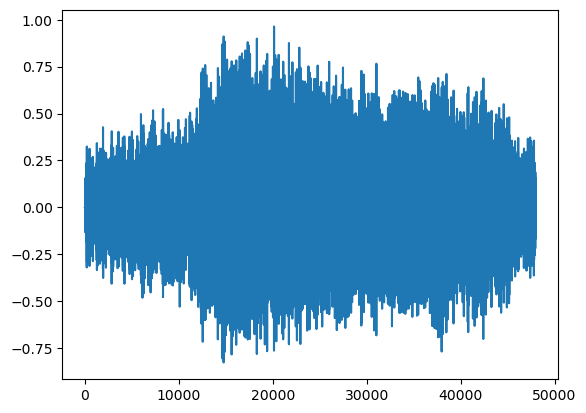

In [6]:
plt.plot(wave)

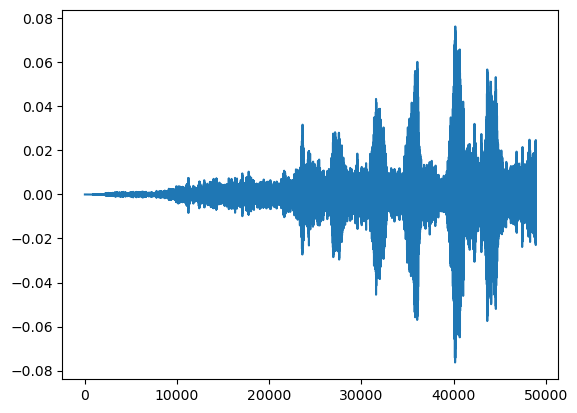

In [7]:
plt.plot(nwave)

### Creating TensorFlow Dataset

In [8]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [11]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
data.as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC3776-5.wav', 1.0)

### Determining Average Length of a Capuchin Call

In [13]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [14]:
lengths[:10]

[40000, 48000, 56000, 48000, 56000, 64000, 64000, 64000, 56000, 56000]

In [15]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [16]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [17]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Building the preprocessing functions to convert to Spectogram

In [18]:
def preprocess(file_path, label): 
    wav = load_data(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [19]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [20]:
spectrogram, label = preprocess(filepath, label)

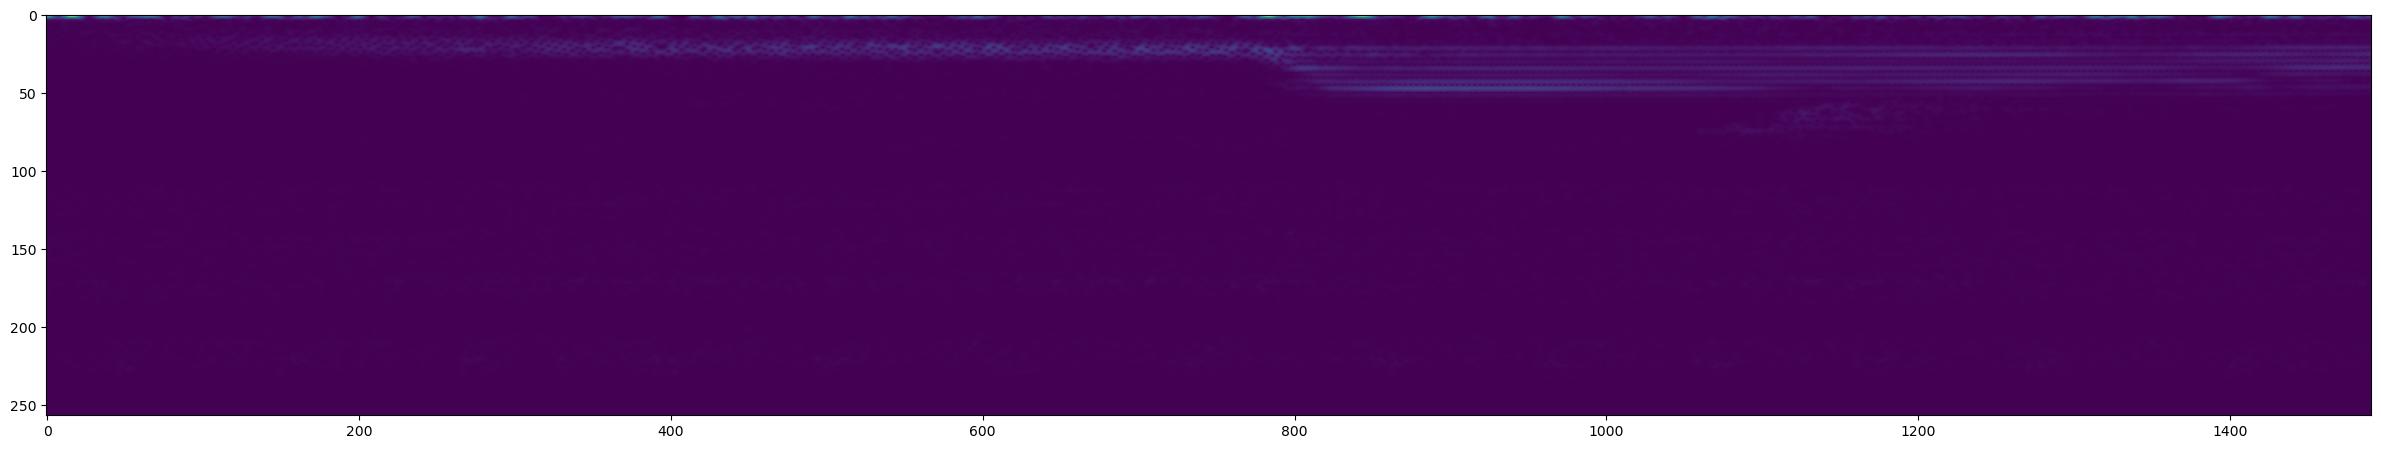

In [21]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Splitting the Data into Training and Testing Portions

In [22]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 1491, 257, 1)

In [26]:
labels.shape

(16,)

In [29]:
model = Sequential()
model.add(Conv2D(8,(3,3),activation = 'relu',input_shape = (1491,257,1)))
model.add(Conv2D(8,(3,3),activation = 'relu'))
model.add(Flatten())
model.add(Dense(16,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [30]:
model.compile('Adam','BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 8)      80        
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten_1 (Flatten)         (None, 3009688)           0         
                                                                 
 dense_2 (Dense)             (None, 16)                48155024  
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,155,705
Trainable params: 48,155,705
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(train,epochs = 1,validation_data = test) #train for more epochs

36/36 [==============================] - 96s 3s/step - loss: 2.7559 - recall_1: 0.9012 - precision_1: 0.8391 - val_loss: 0.0388 - val_recall_1: 0.9559 - val_precision_1: 1.0000


### Building Function to parse large audio clips

In [34]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename) 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [35]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [36]:
wav = load_mp3_16k_mono(mp3)

In [37]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [38]:
samples.shape

(1, 48000)

In [39]:
index.shape

(1,)

In [40]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [42]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 10s 2s/step


In [44]:
from itertools import groupby

yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [45]:
calls

5